In [1]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import opsvis as opsv


In [2]:
# Assumed units: kip, in, ksi

# Material properties
Fy = 50.0
E  = 29000.0
Ix = 301
Sx = 60.0   
Zx = 66.6    
Iy = 103
Sy = 20.5 # in^3 
Zy = 31.1 # in^3    
nu = 0.3
G = 0.5*E/(1+nu)

# Section dimensions from Steel Manual
d  = 10.1
bf = 10.0
tw =  0.370
tf =  0.615
J  =  1.84     #in^4

GJ =  G*J
ky_x = (Fy/E)/(d/2);  print('ky_x =',round(ky_x,6))# curvature at yield x axis bending
ky_y = (Fy/E)/(bf/2);  print('ky_y =',round(ky_y,6))# curvature at yield y axis bending
My_x = Sx * Fy; print('My_x =',round(My_x,3))
Mp_x = Zx * Fy; print('Mp_x =',round(Mp_x,3))
My_y = Sy * Fy; print('My_y =',round(My_y,3))
Mp_y = Zy * Fy; print('Mp_y =',round(Mp_y,3))

# Axial load (positive is compression)
N = 0.0 # Axial loading not used in analysis function


ky_x = 0.000341
ky_y = 0.000345
My_x = 3000.0
Mp_x = 3330.0
My_y = 1025.0
Mp_y = 1555.0


In [3]:
def momCurvAnlyss2D():
    epsY = epsyP
    epsMax = 10*epsyP

    y = -0.5*d # depth to extreme tension fiber
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]

    tsType = 'Linear'      # tsType (str)   time series type
    tsTag  =  1            # tsTag (int)    time series tag          
    ops.timeSeries(tsType,tsTag)
    patternType = 'Plain'  # patternType (str)  pattern type
    patternTag  = 1        # patternTag (int)   pattern tag
    ops.pattern( patternType, patternTag, tsTag) 

    # nodeTag (int)                tag of node to which load is applied.
    # loadValues (list (float))    ndf reference load values.
    ops.load(2,0.0,0.0,1.0) # load(nodeTag, *loadValues)

    # integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
    DCnodeTag = 2           # nodeTag (int)   tag of node whose response controls solution
    DCdof     = 3           # dof (int)       Degree of freedom at the node, 1 through ndf.
    deps = 0.1*epsY         # incr (float)    First displacement increment .
    ops.integrator('DisplacementControl', DCnodeTag, DCdof, deps)
    ops.analysis('Static')
    ops.analyze(1)

    Mplot = np.zeros(1)
    Kplot = np.zeros(1)

    while eps < epsMax:
        ok = ops.analyze(1)
        if ok < 0:
            break

             # eleResponse(eleTag, *args)
        e = ops.eleResponse(1,'section','deformation')
        eps = e[0] - y*e[1]

        Mplot = np.append(Mplot,ops.getLoadFactor(1))
        Kplot = np.append(Kplot,e[1])
    
    k1 = [0.0, ky_x*10 ]
    plotMy = [My_x, My_x] # horizontal line at My
    plotMp = [Mp_x, Mp_x] # horizontal line at Mp
    
    plt.figure()
    plt.plot(Kplot,Mplot)
    plt.plot(k1,plotMy) #plot yield moment
    plt.plot(k1,plotMp) #plot plastic moment
    plt.xlabel('Curvature (1/in)')
    plt.ylabel('Moment (kip-in)')
    plt.title ('EPP, FY = 50ksi, W10x54, Axial Load = %d kip' % N)
    plt.grid()
    plt.show()
    Mmax = round( max(Mplot), 3)
    
    return Mmax

# (#1.) 2D-MODEL STRONG AXIS BENDING WITH 'WFSection2d' COMMAND

WARNING analysis Static - no Algorithm yet specified, 
 NewtonRaphson default will be used
WARNING analysis Static - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Static - no Numberer specified, 
 RCM default will be used
WARNING analysis Static - no LinearSOE specified, 
 ProfileSPDLinSOE default will be used


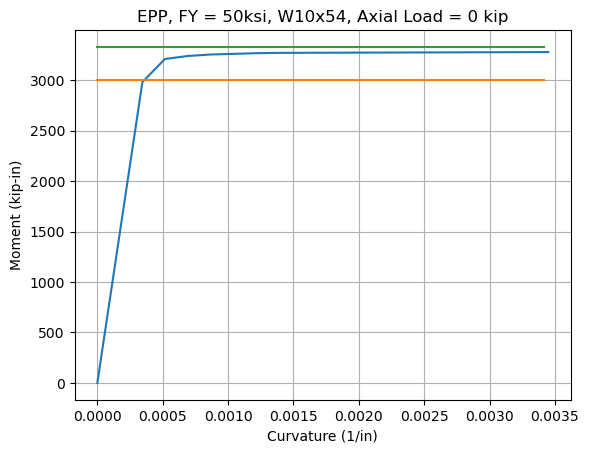

In [5]:
ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0.0,0.0)
ops.node(2,0.0,0.0)

ops.fix(1,1,1,1)
ops.fix(2,0,1,0)

matTag = 1
secTag = 1
eleTag = 1

# ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP, epsyN=epsyP, eps0=0.0)
# matTag (int)   integer tag identifying material
# E (float)      tangent
# epsyP (float)  strain or deformation at which material reaches plastic state in tension
# epsyN (float)  strain or deformation at which material reaches plastic state in compression. (optional, default is tension value)
# eps0 (float)   initial strain (optional, default: zero)
epsyP = Fy/E   # yield strain
ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)

# ops.section('WFSection2d', secTag, matTag, d, tw, bf, tf, Nfw, Nff)
Nfw = 10 # Nfw (float)   number of fibers in the web
Nff = 2  # Nff (float)   number of fibers in each flange    
ops.section('WFSection2d', secTag, matTag, d, tw, bf, tf, Nfw, Nff)

            #('zeroLengthSection', eleTag, *eleNodes, secTag)
ops.element('zeroLengthSection', eleTag, 1, 2, secTag)

Mp_fiber=momCurvAnlyss2D()

In [6]:
print('My_x =',round(My_x,3))
print('Mp_x =',round(Mp_x,3))
print('Mp_fiber =', Mp_fiber)
ratio = Mp_fiber / Mp_x ; print('ratio Mp_fiber:Mp =',round(ratio,3))

My_x = 3000.0
Mp_x = 3330.0
Mp_fiber = 3278.873
ratio Mp_fiber:Mp = 0.985


# (#2.) 2D-MODEL STRONG AXIS BENDING WITH 'patch' COMMAND

WARNING analysis Static - no Algorithm yet specified, 
 NewtonRaphson default will be used
WARNING analysis Static - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Static - no Numberer specified, 
 RCM default will be used
WARNING analysis Static - no LinearSOE specified, 
 ProfileSPDLinSOE default will be used


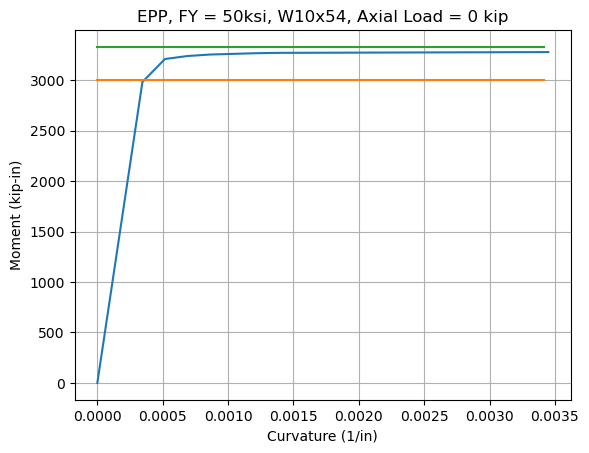

In [8]:
ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0.0,0.0)
ops.node(2,0.0,0.0)

ops.fix(1,1,1,1)
ops.fix(2,0,1,0)

matTag = 1
secTag = 1
eleTag = 1

# ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP, epsyN=epsyP, eps0=0.0)
# matTag (int)   integer tag identifying material
# E (float)      tangent
# epsyP (float)  strain or deformation at which material reaches plastic state in tension
# epsyN (float)  strain or deformation at which material reaches plastic state in compression. (optional, default is tension value)
# eps0 (float)   initial strain (optional, default: zero)
epsyP = Fy/E   # yield strain, epsy = Fy/Es
ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)

ops.section('Fiber',secTag)
ops.patch('rect',matTag,2,1,0.5*d,0.5*bf,0.5*d-tf,-0.5*bf) # Top flange
ops.patch('rect',matTag,10,1,0.5*d-tf,0.5*tw,-0.5*d+tf,-0.5*tw) # Web
ops.patch('rect',matTag,2,1,-0.5*d+tf,0.5*bf,-0.5*d,-0.5*bf) # Bottom flange

            #('zeroLengthSection', eleTag, *eleNodes, secTag)
ops.element('zeroLengthSection', eleTag, 1, 2, secTag)

Mp_fiber=momCurvAnlyss2D()

In [9]:
print('My_x =',round(My_x,3))
print('Mp_x =',round(Mp_x,3))
print('Mp_fiber =', Mp_fiber)
ratio = Mp_fiber / Mp_x ; print('ratio Mp_fiber:Mp =',round(ratio,3))

My_x = 3000.0
Mp_x = 3330.0
Mp_fiber = 3278.873
ratio Mp_fiber:Mp = 0.985


# (#3.) 3D-MODEL WEAK AXIS BENDING WITH 'patch' COMMAND
Weak axis bending with the section discretized along both the y and z axes using the patch command. Also define a torsional stiffness, GJ, for the fiber section.

In [11]:
ops.wipe()
ops.model('basic','-ndm',3,'-ndf',6)

In [12]:
ops.node(1,0.0,0.0,0.0)
ops.node(2,0.0,0.0,0.0)

ops.fix(1, 1,1,1,1,1,1)
ops.fix(2, 0,1,1,0,0,0) #fix dof 2 & 3

matTag = 1 
secTag = 1
eleTag = 1


epsyP = Fy/E   # yield strain, epsy = Fy/E
ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)

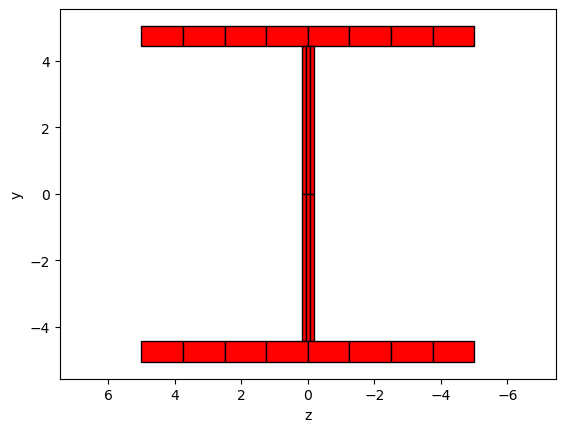

In [13]:
fib_sec_1 =     [['section', 'Fiber', secTag, '-GJ', GJ],
                 [ 'patch', 'rect', matTag, 1, 8,  0.5*d   , 0.5*bf,  0.5*d-tf, -0.5*bf],   # Top flange
                 [ 'patch', 'rect', matTag, 2, 3,  0.5*d-tf, 0.5*tw, -0.5*d+tf, -0.5*tw],   # Web
                 [ 'patch', 'rect', matTag, 1, 8, -0.5*d+tf, 0.5*bf, -0.5*d   , -0.5*bf]   # Bottom flange
                 ]
opsv.fib_sec_list_to_cmds(fib_sec_1)
matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
opsv.plot_fiber_section(fib_sec_1, matcolor=matcolor)
plt.axis('equal')
# plt.savefig('fibsec_rc.png')
plt.show()

In [14]:
        # ('zeroLengthSection', eleTag, *eleNodes, secTag)
ops.element('zeroLengthSection', eleTag, 1, 2, secTag)

WARNING analysis Static - no Algorithm yet specified, 
 NewtonRaphson default will be used
WARNING analysis Static - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Static - no Numberer specified, 
 RCM default will be used
WARNING analysis Static - no LinearSOE specified, 
 ProfileSPDLinSOE default will be used
ProfileSPDLinDirectSolver::solve() -  aii < minDiagTol (i, aii): (2, 1.24255e-30)
WARNING NewtonRaphson::solveCurrentStep() -the LinearSysOfEqn failed in solve()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1551.15
OpenSees > analyze failed, returned: -3 error flag


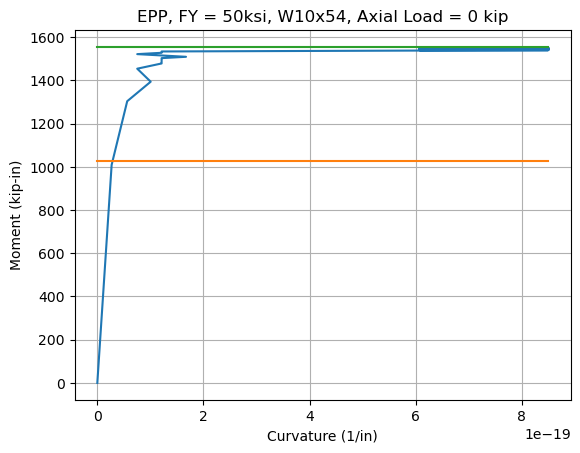

In [15]:
epsY = epsyP
epsMax = 0.01

y = -0.5*bf # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

tsType = 'Linear'      # tsType (str)   time series type
tsTag  =  1            # tsTag (int)    time series tag          
ops.timeSeries(tsType,tsTag)
patternType = 'Plain'  # patternType (str)  pattern type
patternTag  = 1        # patternTag (int)   pattern tag
ops.pattern( patternType, patternTag, tsTag) 

# nodeTag (int)                tag of node to which load is applied.
# loadValues (list (float))    ndf reference load values.
ops.load(2, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0) # load(nodeTag, *loadValues)

# integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
DCnodeTag = 2           # nodeTag (int)   tag of node whose response controls solution
DCdof     = 5           # dof (int)       Degree of freedom at the node, 1 through ndf.
deps = 0.1*epsY        # incr (float)    First displacement increment .
ops.integrator('DisplacementControl', DCnodeTag, DCdof, deps, 1000, .1*deps, deps)

# dlambda1=10
# ops.integrator('MinUnbalDispNorm', dlambda1)


# incr=.01
# ops.integrator('LoadControl', incr)


ops.analysis('Static')
ops.analyze(1)

Mplot = np.zeros(1)
Kplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break

         # eleResponse(eleTag, *args)
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]

    Mplot = np.append(Mplot,ops.getLoadFactor(1))
    Kplot = np.append(Kplot,e[1])


k1 = [0.0, max(Kplot) ]
plotMy = [My_y, My_y] # horizontal line at My
plotMp = [Mp_y, Mp_y] # horizontal line at Mp
    
    
plt.figure()
plt.plot(Kplot,Mplot)
plt.plot(k1,plotMy)
plt.plot(k1,plotMp)
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title ('EPP, FY = 50ksi, W10x54, Axial Load = %d kip' % N)
plt.grid()
plt.show()

Mp_fiber = round( max(Mplot), 3)

In [16]:
print('My_y =',round(My_y,3))
print('Mp_y =',round(Mp_y,3))
print('Mpfiber =', Mp_fiber)
ratio = Mp_fiber / Mp_y ; print('ratio Mp_fiber:Mp =',round(ratio,3))

My_y = 1025.0
Mp_y = 1555.0
Mpfiber = 1550.979
ratio Mp_fiber:Mp = 0.997


## Not an accurate curve but it got the strength right.  Doe